In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rc('font', family='NanumGothic') # For Windows
mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)

In [3]:
preprocessed_path = './csv/preprocessed'
df = pd.read_csv(f'{preprocessed_path}/data_preprocessed.csv')
df_2019 = pd.read_csv(f'{preprocessed_path}/data_2019_diabetes.csv')

In [4]:
df_2019 = df.append(df_2019.loc[df_2019['식전혈당']!=0])
df_2019 = df_2019.sample(frac=1).reset_index(drop=True)

In [5]:
print(df.shape)
print(df_2019.shape)

(1286300, 19)
(1421674, 19)


In [6]:
df.head()

,성별코드,연령대 코드,허리둘레,식전혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,AST,ALT,감마지티피,흡연상태,음주여부,복부비만,비만여부,고혈압
0,1,8,90.0,0.0,193.0,92.0,48.0,126.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1.0,1.0,1.0,1.0
1,1,7,89.0,1.0,228.0,121.0,55.0,148.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0.0,0.0,0.0,1.0
2,1,9,91.0,0.0,136.0,104.0,41.0,74.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0.0,1.0,1.0,1.0
3,1,11,91.0,0.0,201.0,106.0,76.0,104.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0.0,1.0,1.0,2.0
4,1,11,80.0,1.0,199.0,104.0,61.0,117.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0.0,0.0,0.0,1.0


In [7]:
df.columns

Index(['성별코드', '연령대 코드', '허리둘레', '식전혈당', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤',
       'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', 'AST', 'ALT', '감마지티피', '흡연상태',
       '음주여부', '복부비만', '비만여부', '고혈압'],
      dtype='object')

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from pandas import set_option
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [22]:
def GetTrainTest(df):
    X =  df.loc[:, df.columns != '식전혈당']
    Y = df['식전혈당']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
    
    return X_train, X_test, y_train, y_test

def GetBasedModel(cw='balanced'):
    basedModels = []
    
    #Linear Model
    basedModels.append(LogisticRegression(class_weight=cw))
    basedModels.append(Perceptron(class_weight=cw))
    
    #Nearest Neighborhood
    #basedModels.append(KNeighborsClassifier()) Not Suitable for imbalanced data
    
    #Tree
    basedModels.append(DecisionTreeClassifier(class_weight=cw))
    
    #Naives Bayes
    basedModels.append(ComplementNB()) #Suitable NB for Imbalanced Data
    
    #SVM
    #basedModels.append(SVC(probability=True)) 시간이 너무 오래 걸림
    
    #Ensemble Methods
    basedModels.append(AdaBoostClassifier())
    #basedModels.append(GradientBoostingClassifier())
    basedModels.append(LGBMClassifier())
    basedModels.append(RandomForestClassifier())
    
    return basedModels

def EvaluateModel(X, Y, models, scoring='accuracy'):
    names = []
    results = []
    
    for model in models:
        tic = time.perf_counter()
        name = model.__class__.__name__
        cv_result = cross_val_score(model, X, Y, scoring=scoring, cv = 3)
        results.append(cv_result)
        names.append(name)
        toc = time.perf_counter()
        msg = "%s: %f (%0.4f seconds)" % (name, cv_result.mean(), round((toc-tic), 4))
        print(msg)
        
    return names, results

def EvaluateModel2(X, y, models):
    names = []
    accuracy_results = []
    f1_results = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    for model in models:
        tic = time.perf_counter()
        name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        names.append(name)
        accuracy =  accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracy_results.append(accuracy)
        f1_results.append(f1)
        toc = time.perf_counter()
        msg = "%s: %f %f (%0.4f seconds)" % (name, accuracy, f1, round((toc-tic), 4))
        print(msg)
        
    return names, accuracy_results, f1_results


def ScoreDataFrame(names,results):
    #https://www.kaggle.com/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

def ScoreDataFrame2(names,results):
    #https://www.kaggle.com/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r,4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [10]:
df.loc[df['식전혈당'] == 1, '식전혈당'] = 0
df.loc[df['식전혈당'] == 2, '식전혈당'] = 1

df_2019.loc[df_2019['식전혈당'] == 1, '식전혈당'] = 0
df_2019.loc[df_2019['식전혈당'] == 2, '식전혈당'] = 1

X =  df.loc[:, df.columns != '식전혈당']
y = df['식전혈당']

X_2019 =  df_2019.loc[:, df.columns != '식전혈당']
y_2019 = df_2019['식전혈당']

## Feature Selection

In [11]:
features = []

In [ ]:
#Feature Selection using RFE
#rfe = RFE(model)
#fit = rfe.fit(X, y)
#X_rfe = X.columns.values[fit.get_support()]
#print("Num Featrues: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)
#print(X_rfe)
#features.append(('X_rfe', X_rfe))

In [ ]:
#Feature Selection using Information Gain
def Entropy(df, attribute) :
    list1  = list(df[attribute].unique())
    etp = 0
    for i in range(len(list1)):
        q1 = len(df[df[attribute] == list1[i]])/len(df[attribute])
        etp -=  q1*np.log2(q1)
    return etp


def Group_info(df,m_attribute,fix_attribute):
    list2 = list(df[m_attribute].unique())
    info_Entropy = Entropy(df,fix_attribute)
    info_data = 0
    for i in range (len(list2)) :
        q2 = df.loc[df[m_attribute] == list2[i]]
        info_data +=  (len(q2[m_attribute])/len(df[m_attribute]))* Entropy(q2,fix_attribute) 
    
    data = info_Entropy - info_data
    
    return data

info = X.columns

info_gain = []

for i in info:
    info_gain.append(Group_info(df, i, "식전혈당"))
    
EntropyDataFrame = pd.DataFrame({'Columns':info, 'Entropy': info_gain})
EntropyDataFrame.sort_values(by = ['Entropy'], ascending=False, inplace = True)
EntropyDataFrame

threshold = 0.02
X_info = EntropyDataFrame.loc[EntropyDataFrame['Entropy']>threshold].Columns
print("Num Features: %d" % X_info.shape[0])
print("Selected Features: %s" % X_info.values)
features.append(('X_info', X_info.values))

In [ ]:
#Feature Selection using Logistic Regression, Gradient Boost Classifier, RandomForestClassifier
models = []
models.append(('LR', LogisticRegression()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))

for name, model in models:
    fit = SelectFromModel(estimator=model).fit(X, y)
    X_name = 'X_'+name
    X_fs = X.columns.values[fit.get_support()]
    print(X_name)
    print("Num Features: %d" % X_fs.shape[0])
    print("Selected Features: %s" % X_fs)
    features.append((X_name, X_fs))

In [12]:
features.append(('X_info', np.array(['허리둘레', '감마지티피', '연령대 코드', '트리글리세라이드', 'ALT', '고혈압', '복부비만', '비만여부'])))
features.append(('X_LR', np.array(['성별코드', '연령대 코드', '요단백', '음주여부', '복부비만', '비만여부', '고혈압'])))
features.append(('X_GBM', np.array(['연령대 코드', '허리둘레', '트리글리세라이드', '감마지티피', '고혈압'])))
features.append(('X_RF', np.array(['연령대 코드', '허리둘레', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', 'AST',
 'ALT', '감마지티피'])))
features



[('X_info', array(['허리둘레', '감마지티피', '연령대 코드', '트리글리세라이드', 'ALT', '고혈압', '복부비만',
         '비만여부'], dtype='<U8')),
 ('X_LR', array(['성별코드', '연령대 코드', '요단백', '음주여부', '복부비만', '비만여부', '고혈압'],
        dtype='<U6')),
 ('X_GBM', array(['연령대 코드', '허리둘레', '트리글리세라이드', '감마지티피', '고혈압'], dtype='<U8')),
 ('X_RF',
  array(['연령대 코드', '허리둘레', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
         '혈색소', 'AST', 'ALT', '감마지티피'], dtype='<U8'))]

## Model Comparison

In [33]:
def make_plot(ComparePlot):
    ComparePlot.plot(x="Model",linestyle='--', marker='o', grid=True, figsize=(10, 4))
    model_labels = ['LR', 'PCT', 'DT', 'CNB', 'AB', 'GBM', 'RF']
    plt.title('Model Comparison')
    locs, labels = plt.xticks()
    plt.xticks((locs+1)[:7], model_labels)
    plt.show()

### 17-18

In [23]:
models = GetBasedModel()
score_name = ['Model']
acc_list = []
f1_list = []
name_list = []

for model in models:
    name = model.__class__.__name__
    name_list.append(name)
    
AccuracyComparison = pd.DataFrame(name_list, columns = ['Model'])
F1Comparison = pd.DataFrame(name_list, columns = ['Model'])

In [24]:
for name, X_feat in features:
    print(name)
    score_name.append('Score'+name[1:])
    names, acc_results, f1_results = EvaluateModel2(X[X_feat], y, models)
    acc_list.append((name, acc_results))
    f1_list.append((name, f1_results))
    basedLineScore = ScoreDataFrame2(names,acc_results)
    basedLineScore2 = ScoreDataFrame2(names,f1_results)
    AccuracyComparison = AccuracyComparison.merge(basedLineScore, on='Model', how='left')
    F1Comparison = F1Comparison.merge(basedLineScore2, on='Model', how='left')
    print()

X_info
LogisticRegression: 0.672720 0.522914 (15.9660 seconds)
Perceptron: 0.517484 0.432560 (1.5096 seconds)
DecisionTreeClassifier: 0.866303 0.533468 (13.4936 seconds)
ComplementNB: 0.762975 0.533035 (0.4848 seconds)
AdaBoostClassifier: 0.922028 0.483176 (71.2493 seconds)
GradientBoostingClassifier: 0.922063 0.480670 (152.1750 seconds)
RandomForestClassifier: 0.918444 0.497339 (37.9042 seconds)

X_LR
LogisticRegression: 0.660623 0.512094 (3.7834 seconds)
Perceptron: 0.136477 0.136177 (1.6816 seconds)
DecisionTreeClassifier: 0.607362 0.485022 (4.5502 seconds)
ComplementNB: 0.667061 0.497212 (0.4629 seconds)
AdaBoostClassifier: 0.922044 0.488523 (46.2896 seconds)
GradientBoostingClassifier: 0.922234 0.481413 (98.2197 seconds)
RandomForestClassifier: 0.921721 0.491159 (13.6554 seconds)

X_GBM
LogisticRegression: 0.674050 0.522597 (8.8835 seconds)
Perceptron: 0.083231 0.078205 (1.4414 seconds)
DecisionTreeClassifier: 0.862070 0.532216 (12.1675 seconds)
ComplementNB: 0.761028 0.532285 (0.

In [26]:
AccuracyComparison.columns = score_name
AccuracyComparison

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.6727,0.6606,0.6740,0.6896
1,Perceptron,0.5175,0.1365,0.0832,0.1124
2,DecisionTreeClassifier,0.8663,0.6074,0.8621,0.8710
3,ComplementNB,0.7630,0.6671,0.7610,0.7332
4,AdaBoostClassifier,0.9220,0.9220,0.9213,0.9212
5,GradientBoostingClassifier,0.9221,0.9222,0.9214,0.9219
6,RandomForestClassifier,0.9184,0.9217,0.9103,0.9192


In [27]:
F1Comparison.columns = score_name
F1Comparison

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.5229,0.5121,0.5226,0.5347
1,Perceptron,0.4326,0.1362,0.0782,0.1108
2,DecisionTreeClassifier,0.5335,0.4850,0.5322,0.5445
3,ComplementNB,0.5330,0.4972,0.5323,0.5397
4,AdaBoostClassifier,0.4832,0.4885,0.4823,0.5005
5,GradientBoostingClassifier,0.4807,0.4814,0.4800,0.4881
6,RandomForestClassifier,0.4973,0.4912,0.5061,0.5059


## 17-19

In [32]:
models = GetBasedModel()
score_name = ['Model']
acc_list2 = []
f1_list2 = []
name_list = []

for model in models:
    name = model.__class__.__name__
    name_list.append(name)
    
AccuracyComparison_19 = pd.DataFrame(name_list, columns = ['Model'])
F1Comparison_19 = pd.DataFrame(name_list, columns = ['Model'])

In [34]:
for name, X_feat in features:
    print(name)
    score_name.append('Score'+name[1:])
    names, acc_results, f1_results = EvaluateModel2(X_2019[X_feat], y_2019, models)
    acc_list2.append((name, acc_results))
    f1_list2.append((name, f1_results))
    basedLineScore = ScoreDataFrame2(names,acc_results)
    basedLineScore2 = ScoreDataFrame2(names,f1_results)
    AccuracyComparison_19 = AccuracyComparison_19.merge(basedLineScore, on='Model', how='left')
    F1Comparison_19 = F1Comparison_19.merge(basedLineScore2, on='Model', how='left')
    print()

X_info
LogisticRegression: 0.665374 0.529957 (16.3406 seconds)
Perceptron: 0.233904 0.231499 (1.7473 seconds)
DecisionTreeClassifier: 0.848696 0.536796 (15.6822 seconds)
ComplementNB: 0.750731 0.535157 (0.4935 seconds)
AdaBoostClassifier: 0.909596 0.481591 (88.0203 seconds)
GradientBoostingClassifier: 0.909874 0.477571 (185.3407 seconds)
RandomForestClassifier: 0.904982 0.496877 (34.5674 seconds)

X_LR
LogisticRegression: 0.662279 0.523292 (4.4252 seconds)
Perceptron: 0.456831 0.404714 (1.8312 seconds)
DecisionTreeClassifier: 0.598646 0.490210 (4.5354 seconds)
ComplementNB: 0.656149 0.501124 (0.5953 seconds)
AdaBoostClassifier: 0.910451 0.487974 (45.4917 seconds)
GradientBoostingClassifier: 0.910714 0.480225 (104.9973 seconds)
RandomForestClassifier: 0.910271 0.487977 (23.1522 seconds)

X_GBM
LogisticRegression: 0.667857 0.530985 (14.6610 seconds)
Perceptron: 0.215735 0.214551 (3.6543 seconds)
DecisionTreeClassifier: 0.844057 0.534875 (30.1956 seconds)
ComplementNB: 0.753182 0.536212 (

In [35]:
AccuracyComparison_19.columns = score_name
AccuracyComparison_19

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.6654,0.6623,0.6679,0.6833
1,Perceptron,0.2339,0.4568,0.2157,0.0907
2,DecisionTreeClassifier,0.8487,0.5986,0.8441,0.8534
3,ComplementNB,0.7507,0.6561,0.7532,0.7259
4,AdaBoostClassifier,0.9096,0.9105,0.9099,0.9087
5,GradientBoostingClassifier,0.9099,0.9107,0.9101,0.9101
6,RandomForestClassifier,0.9050,0.9103,0.8954,0.9066


In [36]:
F1Comparison_19.columns = score_name
F1Comparison_19

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.5300,0.5233,0.5310,0.5426
1,Perceptron,0.2315,0.4047,0.2146,0.0835
2,DecisionTreeClassifier,0.5368,0.4902,0.5349,0.5486
3,ComplementNB,0.5352,0.5011,0.5362,0.5469
4,AdaBoostClassifier,0.4816,0.4880,0.4806,0.5038
5,GradientBoostingClassifier,0.4776,0.4802,0.4772,0.4868
6,RandomForestClassifier,0.4969,0.4880,0.5092,0.5098


([<matplotlib.axis.XTick at 0x1f3a826eb00>,
 <a list of 7 Text xticklabel objects>)

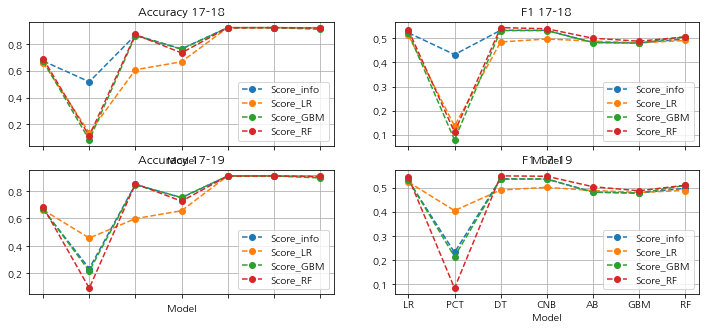

In [69]:
model_labels = ['LR', 'PCT', 'DT', 'CNB', 'AB', 'GBM', 'RF']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

AccuracyComparison.plot(x="Model",linestyle='--', marker='o', grid=True, ax=axes[0, 0], title = "Accuracy 17-18")
AccuracyComparison_19.plot(x="Model",linestyle='--', marker='o', grid=True, ax=axes[1, 0], title = "Accuracy 17-19")
F1Comparison.plot(x="Model",linestyle='--', marker='o', grid=True, ax=axes[0, 1], title = "F1 17-18")
F1Comparison_19.plot(x="Model",linestyle='--', marker='o', grid=True, ax=axes[1, 1], title = "F1 17-19")

locs, labels = plt.xticks()
plt.xticks((locs+1)[:7], model_labels)

### F1 Score Slightly Improved!

## Comparing GBM & LightGBM

In [94]:
from lightgbm import LGBMClassifier

In [95]:
GBMModels = []
GBMModels.append(LGBMClassifier())
GBMModels.append(GradientBoostingClassifier())


score_name = ['Model']
acc_list2 = []
f1_list2 = []
name_list = []

for model in GBMModels:
    name = model.__class__.__name__
    name_list.append(name)
    
AccuracyComparison_GBM = pd.DataFrame(name_list, columns = ['Model'])
F1Comparison_GBM = pd.DataFrame(name_list, columns = ['Model'])

In [102]:
for name, X_feat in features:
    print(name)
    score_name.append('Score'+name[1:])
    names, acc_results, f1_results = EvaluateModel2(X_2019[X_feat], y_2019, GBMModels)
    print()

X_info
LGBMClassifier: 0.910591 0.477620 (9.3240 seconds)
GradientBoostingClassifier: 0.910602 0.478170 (168.5968 seconds)

X_LR
LGBMClassifier: 0.909775 0.477736 (8.4090 seconds)
GradientBoostingClassifier: 0.909835 0.480333 (87.1075 seconds)

X_GBM
LGBMClassifier: 0.910254 0.476744 (7.4469 seconds)
GradientBoostingClassifier: 0.910226 0.477243 (146.1599 seconds)

X_RF
LGBMClassifier: 0.910018 0.482531 (11.3545 seconds)
GradientBoostingClassifier: 0.909881 0.487002 (283.3565 seconds)



### LightGBM과 GBM은 정확도, F1에서 크게 차이가 없지만 걸리는 시간에서 크게 차이가 남

## OverSampling

In [13]:
import imblearn
from imblearn.over_sampling import SMOTE

In [15]:
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

print('SMOTE 적용 전 : ', X_2019.shape, y_2019.shape)
print('SMOTE 적용 후 : ', X_over.shape, y_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over).value_counts())

SMOTE 적용 전 :  (1421674, 18) (1421674,)
SMOTE 적용 후 :  (2372304, 18) (2372304,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    1186152
0.0    1186152
Name: 식전혈당, dtype: int64


In [71]:
def compare_train(X, y, features, models = GetBasedModel()):
    score_name = ['Model']
    acc_list = []
    f1_list = []
    name_list = []

    for model in models:
        name = model.__class__.__name__
        name_list.append(name)
    
    AccuracyComparison = pd.DataFrame(name_list, columns = ['Model'])
    F1Comparison = pd.DataFrame(name_list, columns = ['Model'])

    for name, X_feat in features:
        print(name)
        score_name.append('Score'+name[1:])
        names, acc_results, f1_results = EvaluateModel2(X[X_feat], y, models)
        acc_list.append((name, acc_results))
        f1_list.append((name, f1_results))
        basedLineScore = ScoreDataFrame2(names,acc_results)
        basedLineScore2 = ScoreDataFrame2(names,f1_results)
        AccuracyComparison = AccuracyComparison.merge(basedLineScore, on='Model', how='left')
        F1Comparison = F1Comparison.merge(basedLineScore2, on='Model', how='left')
        print()
        
    AccuracyComparison.columns = score_name
    F1Comparison.columns = score_name
    return AccuracyComparison, F1Comparison

In [26]:
models = GetBasedModel(None)

Accuracy_over, F1_over = compare_train(X_over, y_over, features, models)

X_info


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.675809 0.675328 (18.3932 seconds)
Perceptron: 0.542087 0.470004 (8.5309 seconds)
DecisionTreeClassifier: 0.910593 0.910590 (30.9816 seconds)
ComplementNB: 0.595162 0.579400 (1.9904 seconds)
AdaBoostClassifier: 0.860035 0.859675 (227.2759 seconds)
LGBMClassifier: 0.941319 0.941170 (19.7110 seconds)
RandomForestClassifier: 0.944784 0.944686 (873.9561 seconds)

X_LR
LogisticRegression: 0.710254 0.709957 (9.1671 seconds)
Perceptron: 0.656964 0.626987 (5.4111 seconds)
DecisionTreeClassifier: 0.917983 0.917473 (7.9334 seconds)
ComplementNB: 0.642369 0.641645 (0.9762 seconds)
AdaBoostClassifier: 0.900966 0.900672 (110.0770 seconds)
LGBMClassifier: 0.918092 0.917575 (14.7642 seconds)
RandomForestClassifier: 0.917983 0.917477 (365.7240 seconds)

X_GBM
LogisticRegression: 0.681833 0.681593 (11.0468 seconds)
Perceptron: 0.509186 0.370600 (5.5634 seconds)
DecisionTreeClassifier: 0.909537 0.909537 (29.6115 seconds)
ComplementNB: 0.593520 0.577480 (1.0189 seconds)
AdaBoostClass

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.686522 0.686464 (22.3078 seconds)
Perceptron: 0.688436 0.685149 (23.4700 seconds)
DecisionTreeClassifier: 0.908431 0.908420 (94.6124 seconds)
ComplementNB: 0.647307 0.643774 (1.0587 seconds)
AdaBoostClassifier: 0.747288 0.746886 (280.7190 seconds)
LGBMClassifier: 0.945947 0.945898 (17.6685 seconds)
RandomForestClassifier: 0.954498 0.954491 (1844.7005 seconds)



In [31]:
Accuracy_over

,Model,Score_x,Score_y,Score_x,Score_y
0,LogisticRegression,0.6758,0.7103,0.6818,0.6865
1,Perceptron,0.5421,0.6570,0.5092,0.6884
2,DecisionTreeClassifier,0.9106,0.9180,0.9095,0.9084
3,ComplementNB,0.5952,0.6424,0.5935,0.6473
4,AdaBoostClassifier,0.8600,0.9010,0.8074,0.7473
5,LGBMClassifier,0.9413,0.9181,0.9186,0.9459
6,RandomForestClassifier,0.9448,0.9180,0.9283,0.9545


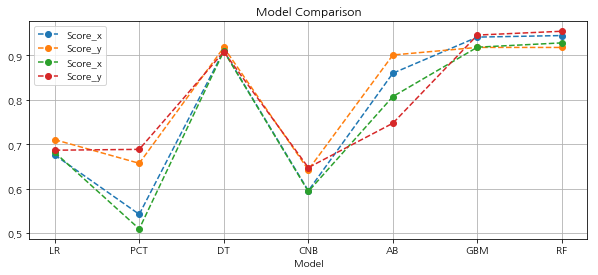

In [34]:
make_plot(Accuracy_over)

In [28]:
F1_over

,Model,Score_x,Score_y,Score_x,Score_y
0,LogisticRegression,0.6753,0.7100,0.6816,0.6865
1,Perceptron,0.4700,0.6270,0.3706,0.6851
2,DecisionTreeClassifier,0.9106,0.9175,0.9095,0.9084
3,ComplementNB,0.5794,0.6416,0.5775,0.6438
4,AdaBoostClassifier,0.8597,0.9007,0.8072,0.7469
5,LGBMClassifier,0.9412,0.9176,0.9185,0.9459
6,RandomForestClassifier,0.9447,0.9175,0.9283,0.9545


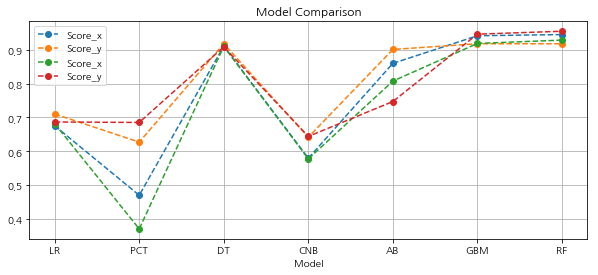

In [35]:
make_plot(F1_over)

In [52]:
model = LGBMClassifier()

X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, shuffle=True)

feat = features[3][1]

model.fit(X_over_train[feat], y_over_train)

y_pred = model.predict(X_over_test[feat])

print("Accuracy Score: %f" %accuracy_score(y_over_test, y_pred))
print("F1 Score: %f" %f1_score(y_over_test, y_pred))
print("ROC Score: %f" %roc_auc_score(y_over_test, y_pred))

Accuracy Score: 0.946152
F1 Score: 0.944539
ROC Score: 0.946173


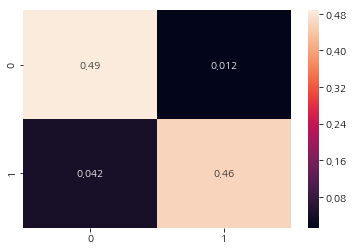

In [54]:
import seaborn as sns

cf = confusion_matrix(y_over_test, y_pred)
sns.heatmap(cf/np.sum(cf), annot=True)

In [78]:
models = GetBasedModel(None)
feat = [['Default', X_over.columns]]

AC, FC = compare_train(X_over, y_over, feat, models)

Default


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.716244 0.716116 (25.3929 seconds)
Perceptron: 0.589509 0.530955 (8.4635 seconds)
DecisionTreeClassifier: 0.920527 0.920523 (46.7860 seconds)
ComplementNB: 0.648726 0.645283 (1.1166 seconds)
AdaBoostClassifier: 0.914792 0.914635 (363.5395 seconds)
LGBMClassifier: 0.955096 0.955011 (25.0040 seconds)
RandomForestClassifier: 0.958022 0.957956 (1115.5767 seconds)



Accuracy Score: 0.954934
F1 Score: 0.952939
ROC Score: 0.954965


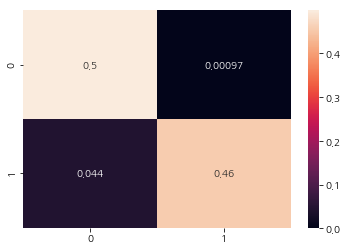

In [81]:
model = LGBMClassifier()

model.fit(X_over_train, y_over_train)

y_pred = model.predict(X_over_test)

print("Accuracy Score: %f" %accuracy_score(y_over_test, y_pred))
print("F1 Score: %f" %f1_score(y_over_test, y_pred))
print("ROC Score: %f" %roc_auc_score(y_over_test, y_pred))

cf_over = confusion_matrix(y_over_test, y_pred)
sns.heatmap(cf_over/np.sum(cf_over), annot=True)

감격스럽다

## UnderSampling

In [59]:
count_class_0, count_class_1 = pd.Series(y_2019).value_counts()

df_class_0 = df_2019[df_2019['식전혈당'] == 0]
df_class_1 = df_2019[df_2019['식전혈당'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

X_under = df_under.loc[:, df_under.columns != '식전혈당']
y_under = df_under['식전혈당']

print('UnderSampling 적용 전 : ', X_2019.shape, y_2019.shape)
print('UnderSampling 적용 후 : ', X_under.shape, y_under.shape)
print('UnderSampling 적용 전 레이블 값 분포: \n', pd.Series(y_2019).value_counts())
print('UnderSampling 적용 후 레이블 값 분포: \n', pd.Series(y_under).value_counts())

UnderSampling 적용 전 :  (1421674, 18) (1421674,)
UnderSampling 적용 후 :  (256160, 18) (256160,)
UnderSampling 적용 전 레이블 값 분포: 
 0.0    1293594
1.0     128080
Name: 식전혈당, dtype: int64
UnderSampling 적용 후 레이블 값 분포: 
 1.0    128080
0.0    128080
Name: 식전혈당, dtype: int64


In [61]:
models = GetBasedModel(None)

Accuracy_under, F1_under = compare_train(X_under, y_under, features, models)

X_info


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.664936 0.664925 (2.0821 seconds)
Perceptron: 0.575988 0.489364 (0.8733 seconds)
DecisionTreeClassifier: 0.601597 0.601586 (1.4941 seconds)
ComplementNB: 0.585962 0.568302 (0.0943 seconds)
AdaBoostClassifier: 0.692516 0.691718 (8.2115 seconds)
LGBMClassifier: 0.696049 0.693579 (1.3829 seconds)
RandomForestClassifier: 0.678228 0.677216 (36.2370 seconds)

X_LR
LogisticRegression: 0.668762 0.668749 (1.2503 seconds)
Perceptron: 0.516084 0.370126 (0.4235 seconds)
DecisionTreeClassifier: 0.672490 0.669951 (0.2955 seconds)
ComplementNB: 0.609248 0.607751 (0.0925 seconds)
AdaBoostClassifier: 0.671885 0.671468 (5.8868 seconds)
LGBMClassifier: 0.677662 0.674289 (1.4187 seconds)
RandomForestClassifier: 0.673759 0.671032 (13.2492 seconds)

X_GBM
LogisticRegression: 0.685938 0.685816 (1.3861 seconds)
Perceptron: 0.627635 0.625179 (1.3679 seconds)
DecisionTreeClassifier: 0.599196 0.599173 (1.1179 seconds)
ComplementNB: 0.586957 0.568634 (0.0945 seconds)
AdaBoostClassifier: 0.692

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.689510 0.689423 (2.2131 seconds)
Perceptron: 0.609404 0.561515 (0.4010 seconds)
DecisionTreeClassifier: 0.624122 0.624121 (3.1304 seconds)
ComplementNB: 0.645222 0.641766 (0.1091 seconds)
AdaBoostClassifier: 0.712094 0.711809 (10.7051 seconds)
LGBMClassifier: 0.722829 0.721849 (1.7350 seconds)
RandomForestClassifier: 0.716369 0.715708 (62.5251 seconds)



In [62]:
Accuracy_under

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.6649,0.6688,0.6859,0.6895
1,Perceptron,0.5760,0.5161,0.6276,0.6094
2,DecisionTreeClassifier,0.6016,0.6725,0.5992,0.6241
3,ComplementNB,0.5860,0.6092,0.5870,0.6452
4,AdaBoostClassifier,0.6925,0.6719,0.6921,0.7121
5,LGBMClassifier,0.6960,0.6777,0.6946,0.7228
6,RandomForestClassifier,0.6782,0.6738,0.6607,0.7164


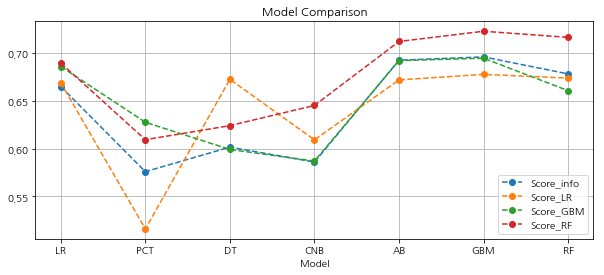

In [63]:
make_plot(Accuracy_under)

In [64]:
F1_under

,Model,Score_info,Score_LR,Score_GBM,Score_RF
0,LogisticRegression,0.6649,0.6687,0.6858,0.6894
1,Perceptron,0.4894,0.3701,0.6252,0.5615
2,DecisionTreeClassifier,0.6016,0.6700,0.5992,0.6241
3,ComplementNB,0.5683,0.6078,0.5686,0.6418
4,AdaBoostClassifier,0.6917,0.6715,0.6914,0.7118
5,LGBMClassifier,0.6936,0.6743,0.6921,0.7218
6,RandomForestClassifier,0.6772,0.6710,0.6601,0.7157


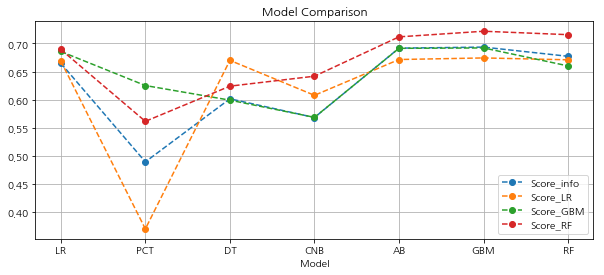

In [65]:
make_plot(F1_under)

In [66]:
model = LGBMClassifier()

X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, shuffle=True)

feat = features[3][1]

model.fit(X_under_train[feat], y_under_train)

LGBMClassifier()

In [67]:
y_pred = model.predict(X_over_test[feat])

print("Accuracy Score: %f" %accuracy_score(y_over_test, y_pred))
print("F1 Score: %f" %f1_score(y_over_test, y_pred))
print("ROC Score: %f" %roc_auc_score(y_over_test, y_pred))

Accuracy Score: 0.722333
F1 Score: 0.731846
ROC Score: 0.722308


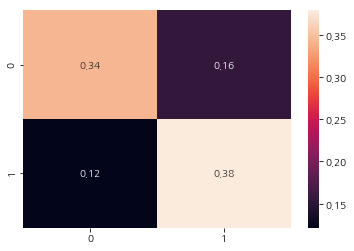

In [68]:
cf = confusion_matrix(y_over_test, y_pred)
sns.heatmap(cf/np.sum(cf), annot=True)